# 582744 Advanced Course in Machine Learning

## Exercise 7.1: Playing with RNNs

This exercise contains most of the code needed in a Python jupyter notebook, you will be asked to fill in some important parts.  Just read the text and run each code cell by selecting and clicking the "run cell" button (play-like button), or by pressing shift-Enter.

In this exercise we'll play a little bit with recurrent neural networks, in particular LSTMs.  We'll create a model that learns to predict the next character from a set of input characters. As training with a real dataset might be a bit too computationally expensive for an exercise, we'll just look at a toy example.

Continue by running the cells below...

In [1]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from keras.utils import np_utils

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import urllib.request

Using TensorFlow backend.


First, we'll create our set of characters to use.  Let's use the lower case letters plus space. (You can edit this if you want to use more characters.)  We also create mapping dictionaries, so that we can easily map from the letter to the corresponding index, e.g., `char_to_int["a"] = 0` and so on.

In [2]:
alphabet = "abcdefghijklmnopqrstuvwxyz. "

char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

Next, we'll prepare some training data with a real sentence. The idea is to predict the next character from the previous one, so we'll make the input-output pairs of consecutive characters from the intput sentence.

In [3]:
# Here are some examples you can use ...

# Learn the alphabet itself, i.e., predict the next letter (this one should be trivial)
#data = "abcdefghijklmnopqrstuvwxyz"

# Learn a sentence (this should be a little bit harder)
data = "hello world this is just a test sentence"

# The "The Adventures of Sherlock Holmes" from Gutenberg.org, this will require hours of training to get 
# anything useful out... this will be a lot harder.  This is not required, but can be fun
# if you have time.
#r = urllib.request.urlopen("http://www.gutenberg.org/cache/epub/1661/pg1661.txt")
#raw_data = r.read().decode('utf8')
#start_idx = raw_data.find("ADVENTURE I")
#end_idx = raw_data.find("End of the Project Gutenberg EBook")
#raw_data = raw_data[start_idx:end_idx]
#data = [ch if ch in alphabet else " " for ch in raw_data.lower()]

#print("Example of processed data:", ''.join(data[:1000]))

dataX = []
dataY = []

verbose = True if len(data) < 50 else False

if verbose:
    print("Training pairs:")
    
for i in range(len(data) - 1):
    seq_in = data[i]
    seq_out = data[i + 1]
    dataX.append(char_to_int[seq_in])
    dataY.append(char_to_int[seq_out])
    if verbose:
        print(seq_in, '->', seq_out)

Training pairs:
h -> e
e -> l
l -> l
l -> o
o ->  
  -> w
w -> o
o -> r
r -> l
l -> d
d ->  
  -> t
t -> h
h -> i
i -> s
s ->  
  -> i
i -> s
s ->  
  -> j
j -> u
u -> s
s -> t
t ->  
  -> a
a ->  
  -> t
t -> e
e -> s
s -> t
t ->  
  -> s
s -> e
e -> n
n -> t
t -> e
e -> n
n -> c
c -> e


Finally, we'll reshape the training data so that `X` is a tensor with the format `(samples, time_steps, features)`. Here we are not using batches, so each item is a time step (`time_steps=1`) and the feature is just the character itself (`features=1`).

The `y` is one-hot-encoded.

In [4]:
X = np.reshape(dataX, (len(dataX), 1, 1))
X = X / float(len(alphabet))

y = np_utils.to_categorical(dataY)

print(X.shape)
print(y.shape)

(39, 1, 1)
(39, 28)


### Initialization

Now, let's create an RNN model using LSTM.

**Here is where you should add some code of your own!**

Due to the way LSTM is implemented in Keras, it will normally reset its cell state after each batch. Here we want to train it in a way that remembers the internal state all the time, unless we explicitly reset it. To do this give the parameter `stateful=True` when you are adding the LSTM layer to the model. We can reset the state explicitly by calling `    model.reset_states()`. We are also not using batches, so each character is a batch of its own, so we use `batch_size=1`.

For the first layer you should then give the parameter: `batch_input_shape=(batch_size, X.shape[1], X.shape[2])`.

As always, the methods needed are described in [Keras' documentation](https://keras.io/).

The output of the last layer needs to be a softmaxed vector to match the alphabet (size `y.shape[1]`).

In [35]:
# Model initialization:
batch_size = 1
model = Sequential()

# Example lines, change these to the correct ones!
model.add(LSTM(y.shape[1], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), return_sequences=True,stateful=True))
model.add(LSTM(3*y.shape[1],activation='sigmoid',dropout=0.1,return_sequences=True,stateful=True))
model.add(LSTM(6*y.shape[1],activation='tanh',dropout=0.1,return_sequences=True,stateful=True))
model.add(LSTM(3*y.shape[1],activation='sigmoid',dropout=0.1,return_sequences=True,stateful=True))
model.add(Flatten())
model.add(Dense(y.shape[1],activation='softmax'))
# Compile and print summary
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (1, 1, 28)                3360      
_________________________________________________________________
lstm_38 (LSTM)               (1, 1, 84)                37968     
_________________________________________________________________
lstm_39 (LSTM)               (1, 1, 168)               170016    
_________________________________________________________________
lstm_40 (LSTM)               (1, 1, 84)                85008     
_________________________________________________________________
flatten_10 (Flatten)         (1, 84)                   0         
_________________________________________________________________
dense_10 (Dense)             (1, 28)                   2380      
Total params: 298,732
Trainable params: 298,732
Non-trainable params: 0
_________________________________________________________________
None

You can also visualise it like this:

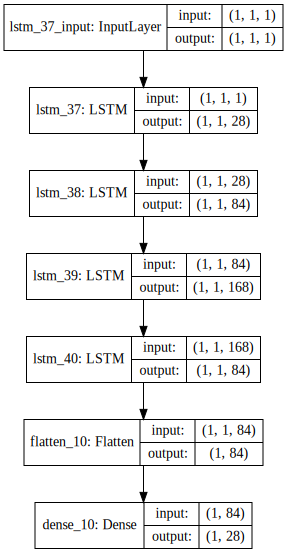

In [40]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Learning

Now let's train the LSTM model. As we have to reset the model manually, we'll run the `model.fit` function for one epoch, do the reset, and then run another in a loop.

If you try with some bigger dataset, use `epocs=1` to start with... otherwise it will take forever. For example with the 30 minutes.

In [36]:
%%time

epocs=300

for i in range(epocs):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()


Epoch 1/1
39/39 [==============================] - 1s - loss: 3.2669 - acc: 0.1026     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.7403 - acc: 0.1795     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.6497 - acc: 0.1795     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.6168 - acc: 0.1795     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.5901 - acc: 0.1795     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.5604 - acc: 0.1795     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.5651 - acc: 0.1795     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.5711 - acc: 0.1282     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.5765 - acc: 0.1795     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.5664 - acc: 0.2051     
Epoch 1/1
39/39 [==============================] - 0s - loss: 2.5530 - acc: 0.2051     
Epoch 1/1
39/39 [===============

39/39 [==============================] - 0s - loss: 1.3673 - acc: 0.4615     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.3168 - acc: 0.4615     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.2591 - acc: 0.5128     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.2490 - acc: 0.4615     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.4621 - acc: 0.4103     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.2599 - acc: 0.5128     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.4292 - acc: 0.3846     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.3422 - acc: 0.5128     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.5590 - acc: 0.3077     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.4340 - acc: 0.5128     
Epoch 1/1
39/39 [==============================] - 0s - loss: 1.2451 - acc: 0.4872     
Epoch 1/1
39/39 [=========================

39/39 [==============================] - ETA: 0s - loss: 0.4536 - acc: 0.727 - 0s - loss: 0.5431 - acc: 0.6667     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.5830 - acc: 0.6667     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.3709 - acc: 0.9487     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.3524 - acc: 0.8974     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.3806 - acc: 0.9231     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.4506 - acc: 0.7949     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.3632 - acc: 0.8718     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.3227 - acc: 0.9487     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.2928 - acc: 0.9744     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.2621 - acc: 0.9744     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.2679 - acc: 0.9744     
Epoc

39/39 [==============================] - 0s - loss: 0.5694 - acc: 0.7179     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.4352 - acc: 0.7949     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.3332 - acc: 0.8974     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.2536 - acc: 0.9744     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.2443 - acc: 0.9744     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.3680 - acc: 0.7949     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.7992 - acc: 0.6154     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.6188 - acc: 0.8205     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.4072 - acc: 0.8462     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.4523 - acc: 0.8205     
Epoch 1/1
39/39 [==============================] - 0s - loss: 0.5765 - acc: 0.6667     
Epoch 1/1
39/39 [=========================

Now, let's see the final accuracy of the model on the training set.

In [37]:
scores = model.evaluate(X, y, batch_size=batch_size, verbose=0)
model.reset_states()
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 94.87%


### Test outputs

Now, let's see some outputs. We'll start by making a function that predicts the next `n` chars given a starting character `start_char`.

In [9]:
def predict_next_chars(start_chars, n, verbose=False):
    all_chars = start_chars
    for i in range(n):
        x = np.reshape(char_to_int[start_chars[0]], (1, 1, 1))
        x = x / float(len(alphabet))
        prediction = model.predict(x, verbose=0)
        
        # if we were given more than one start char, continue feeding those
        if len(start_chars) > 1:
            start_chars = start_chars[1:]
        else: # otherwise, we predict the next character
            next_char = int_to_char[np.argmax(prediction)]
            if verbose:
                print(start_chars, "->", next_char)
            all_chars += next_char
            start_chars = next_char
    model.reset_states()
    print("\nThe full predicted text string:", all_chars)


Let's try inputting the first letter of our training data.  Giving `True` as the third parameter to the function causes it to print each prediction as it happens.  Set it to `False` if you want less verbose output.

In [38]:
predict_next_chars(data[0], 30, True)

h -> e
e -> l
l -> l
l -> o
o ->  
  -> w
w -> o
o -> r
r -> l
l -> d
d ->  
  -> t
t -> h
h -> i
i -> s
s ->  
  -> i
i -> s
s ->  
  -> j
j -> u
u -> s
s -> t
t ->  
  -> a
a ->  
  -> t
t -> e
e -> s
s -> t

The full predicted text string: hello world this is just a test


The output will probably not be perfect, but you should see that it has learned something.  You can try with different starting letters, and experiment with other datasets.

In [39]:
predict_next_chars('abx', 100)


The full predicted text string: abxlo world this is just a test sentcececececececececececececececececelelellllllllololollloltltltldld
